2558475557
Initial State:
Step 0:


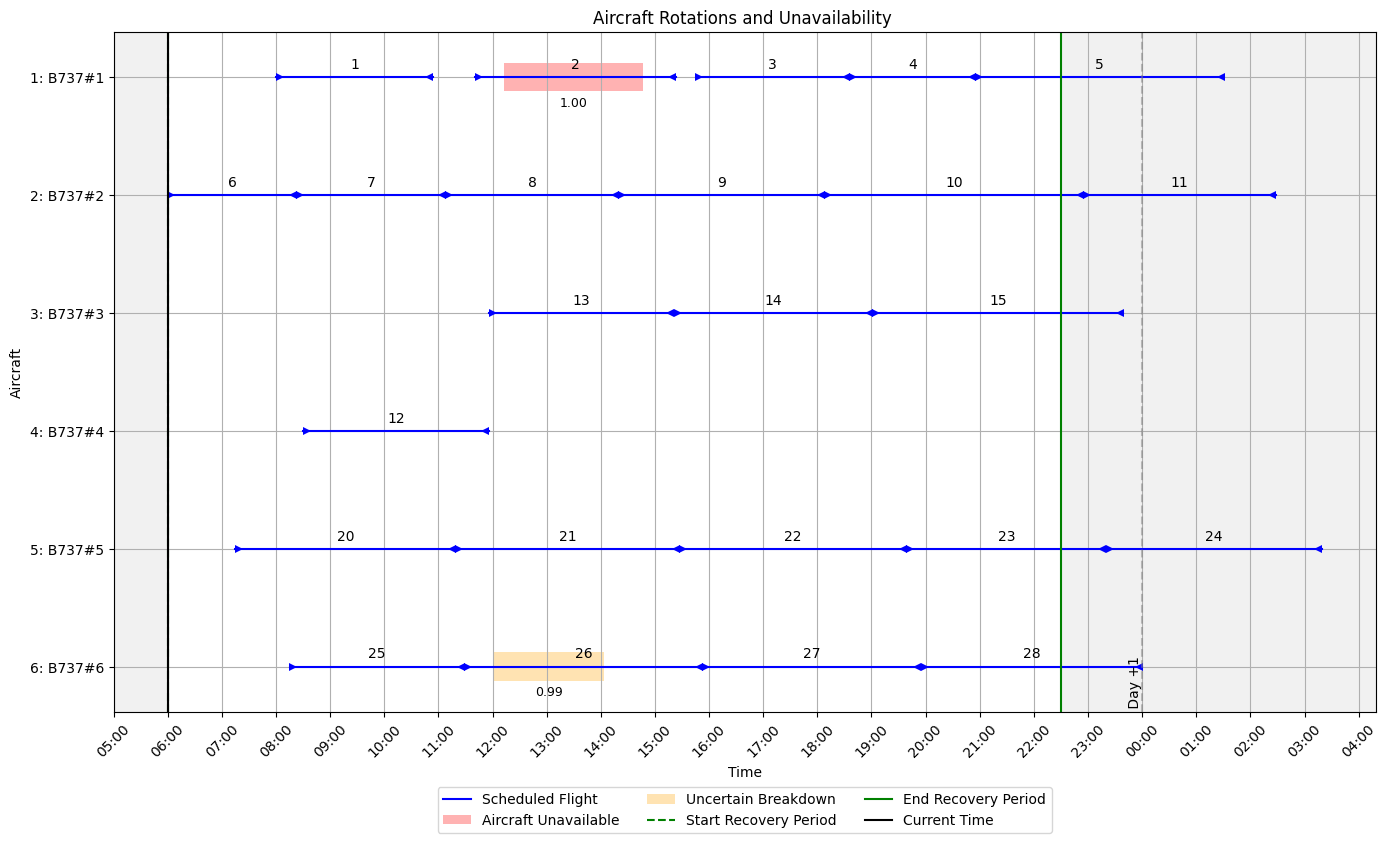


Action selected via: conflicted-random
Action: Flight 26, Aircraft 0
Action taken: Flight 26, Aircraft 0, Reward: -5583.6

Step 1:


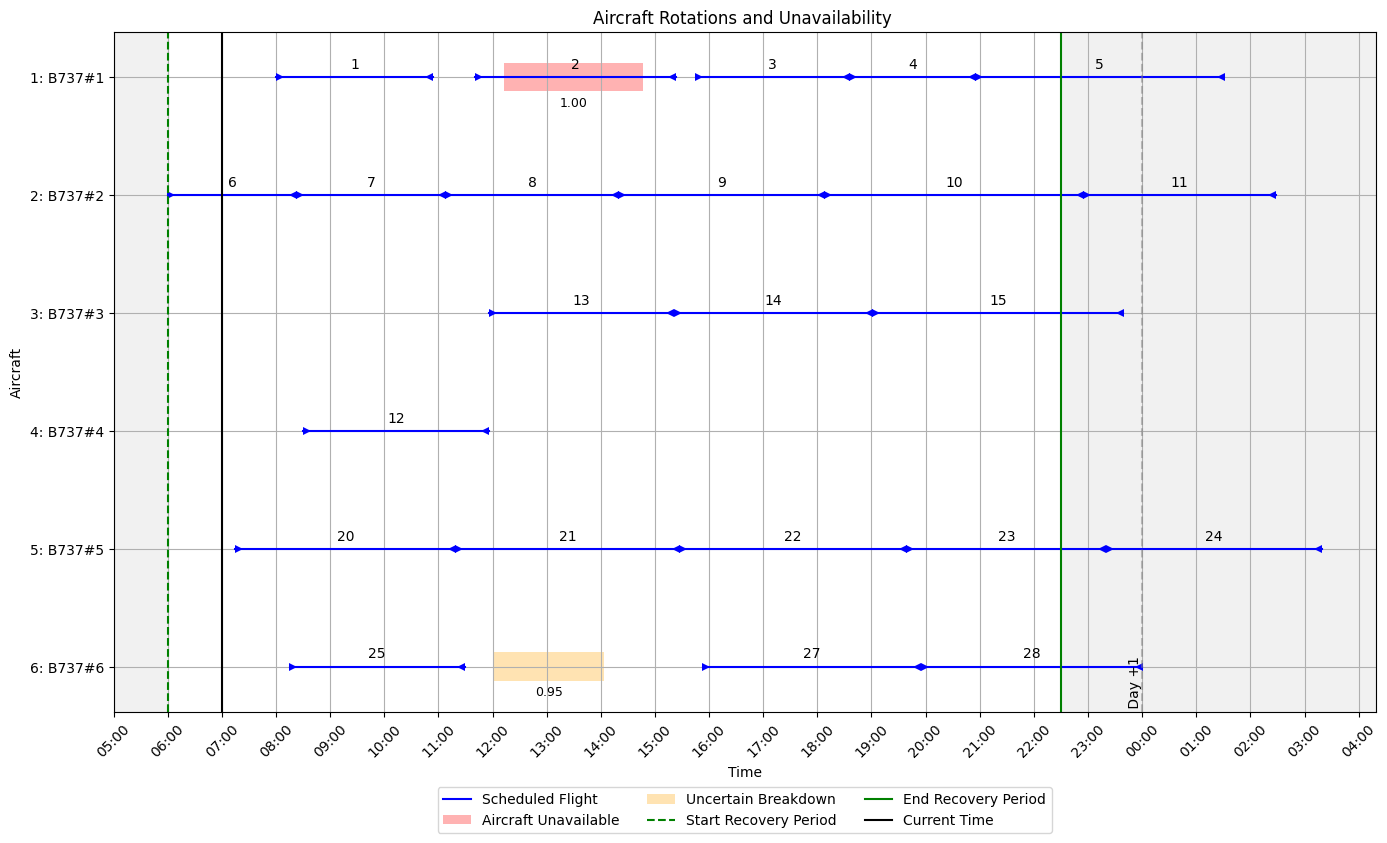


Action selected via: conflicted-random
Action: Flight 2, Aircraft 4
Action taken: Flight 2, Aircraft 4, Reward: -2936.0

Step 2:


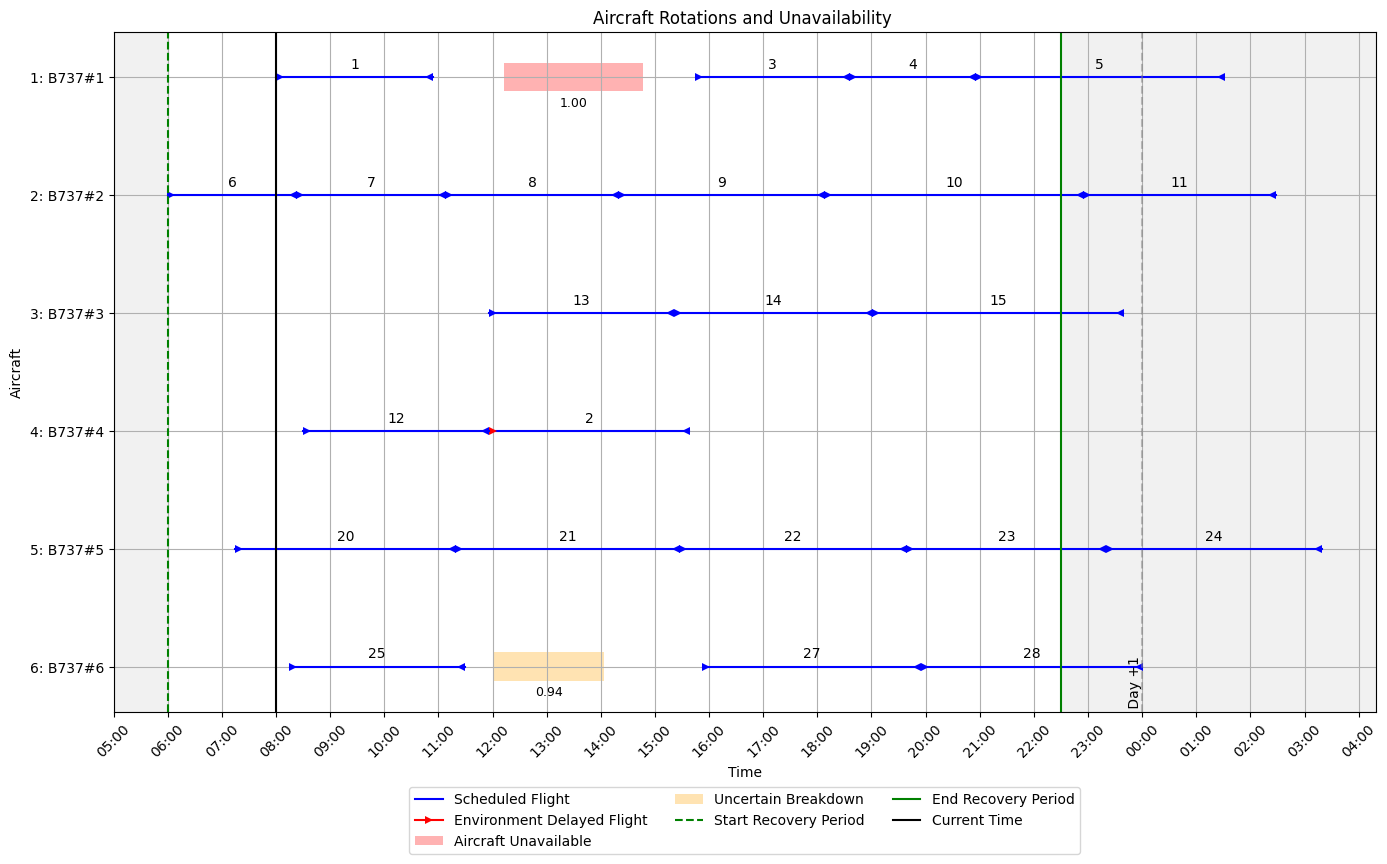


Action selected via: exploration
Action: Flight 7, Aircraft 6
Action taken: Flight 7, Aircraft 6, Reward: -12098.8

Step 3:


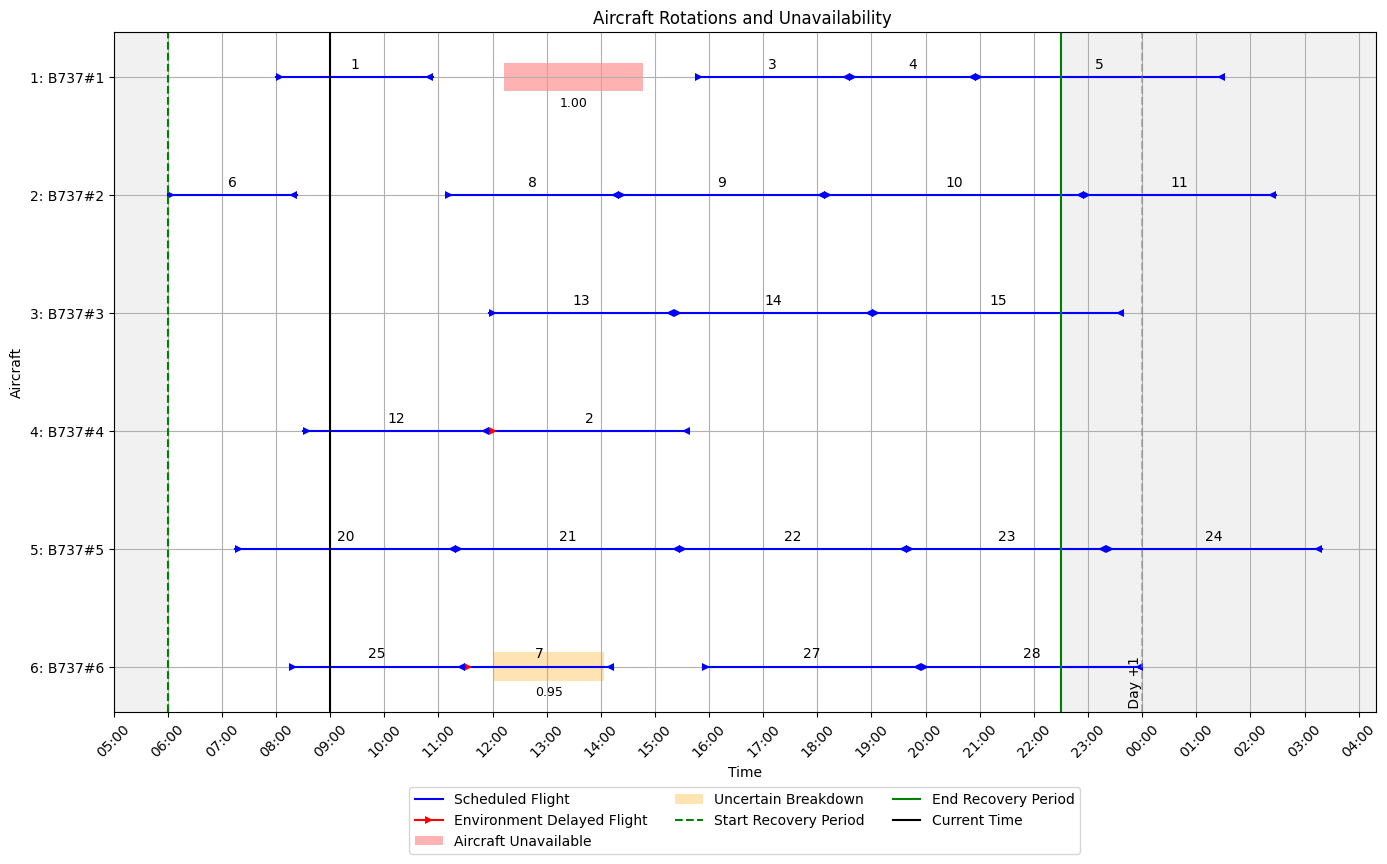


Action selected via: conflicted-random
Action: Flight 7, Aircraft 6
Action taken: Flight 7, Aircraft 6, Reward: -7892.6

Step 4:


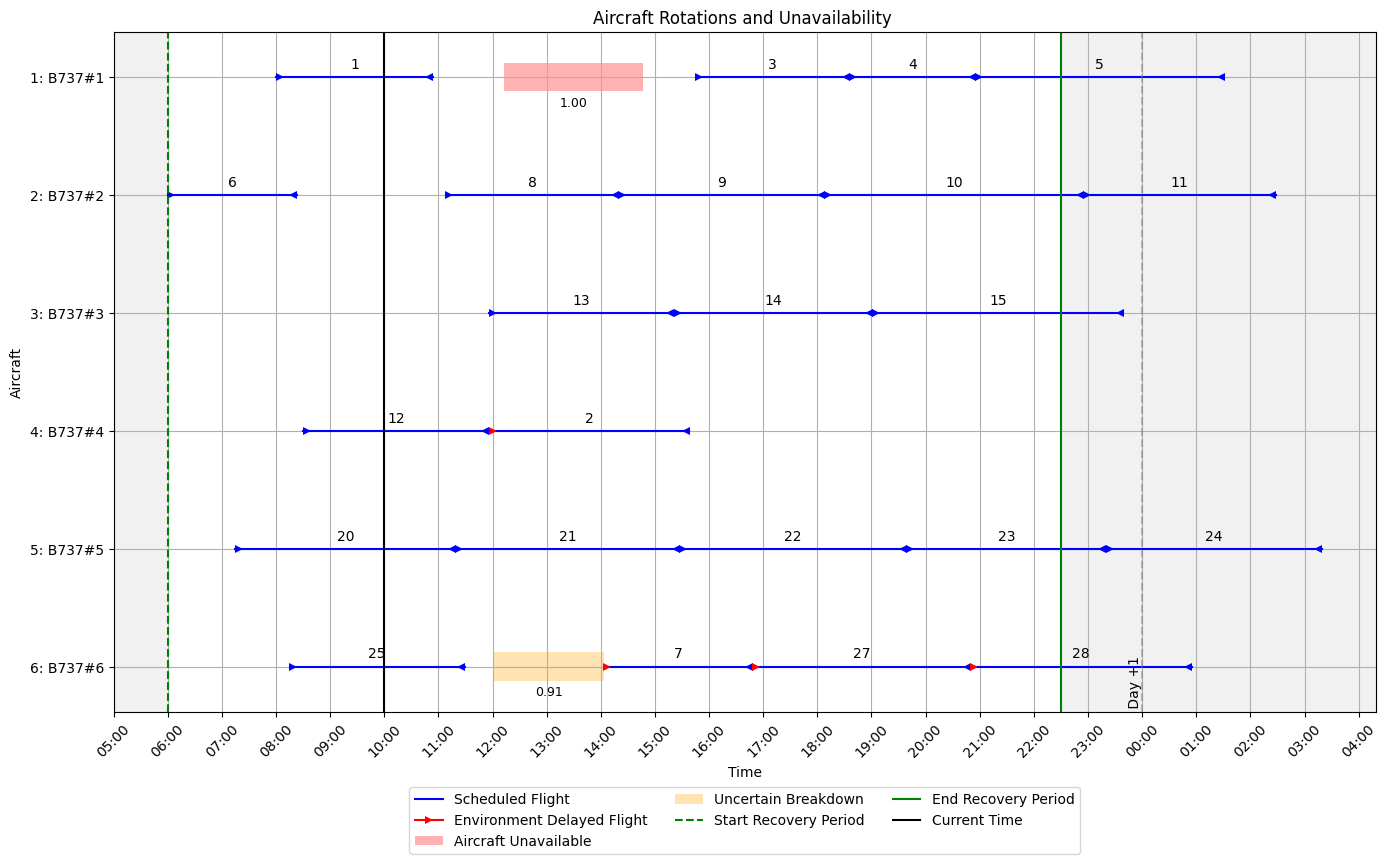


Action selected via: conflicted-random
Action: Flight 0, Aircraft 0
Action taken: Flight 0, Aircraft 0, Reward: 47000.0

Step 5:


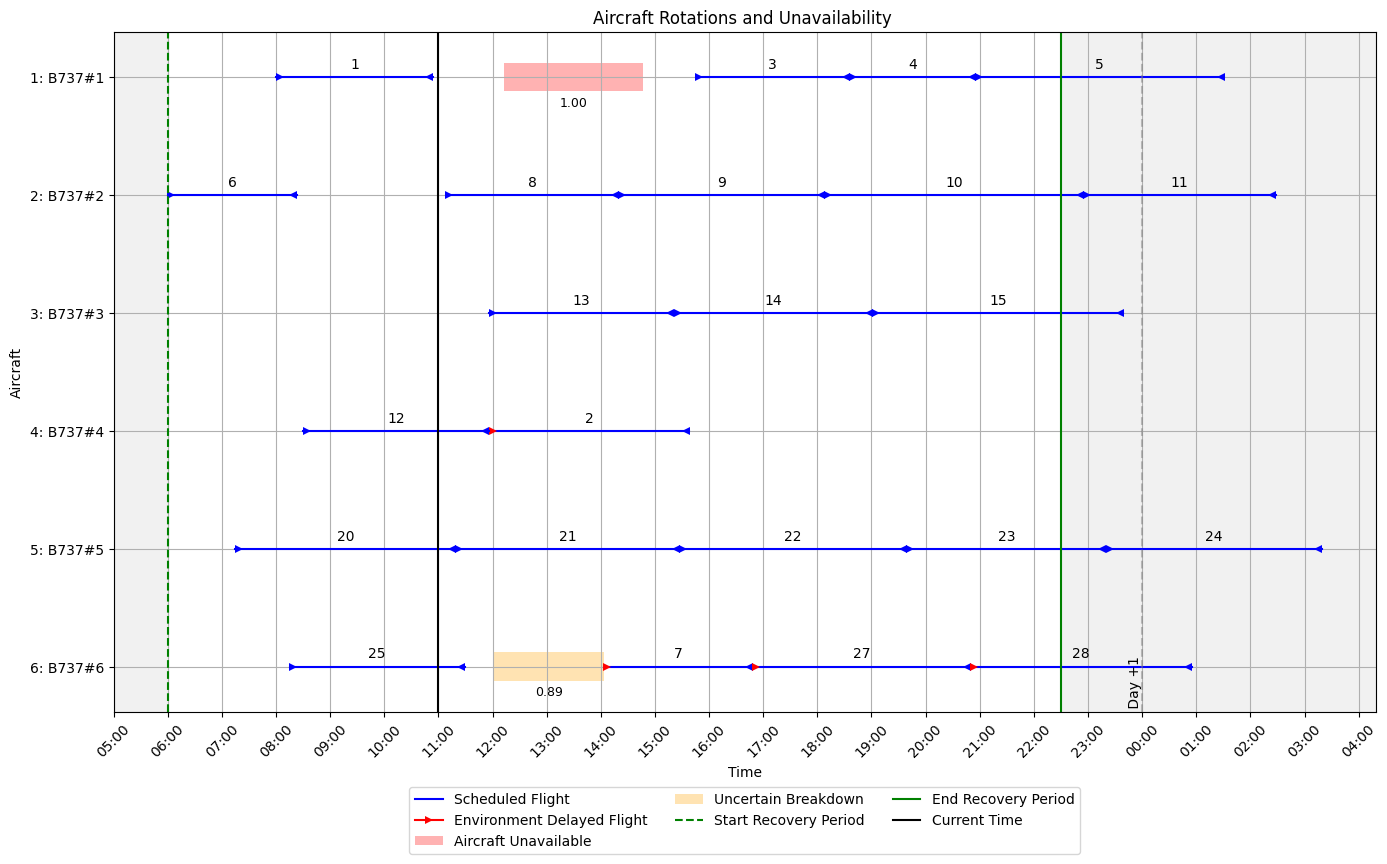


Action selected via: conflicted-random
Action: Flight 0, Aircraft 0
Action taken: Flight 0, Aircraft 0, Reward: 46400.0

Step 6:


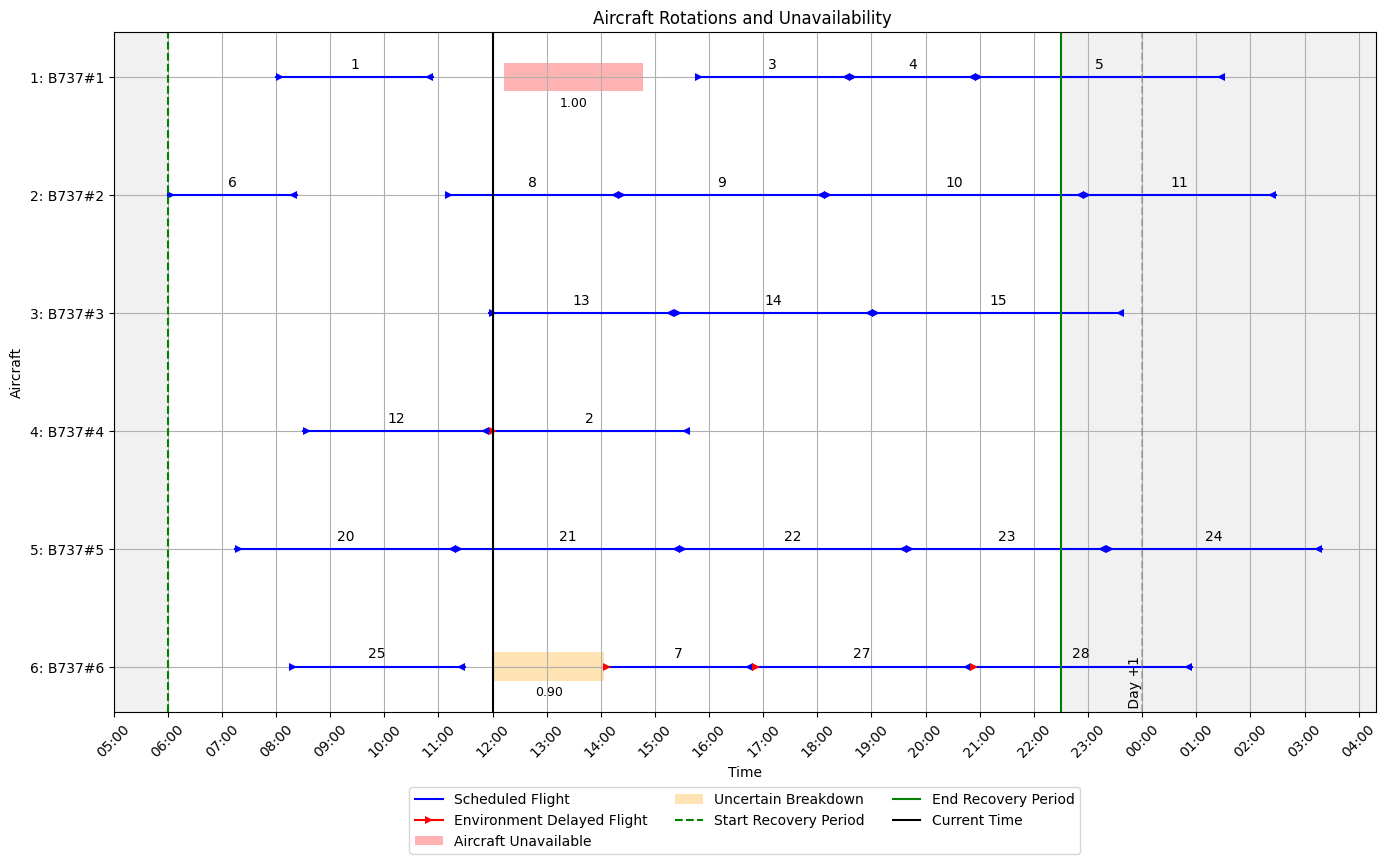


Action selected via: conflicted-random
Action: Flight 0, Aircraft 0
Action taken: Flight 0, Aircraft 0, Reward: 45800.0



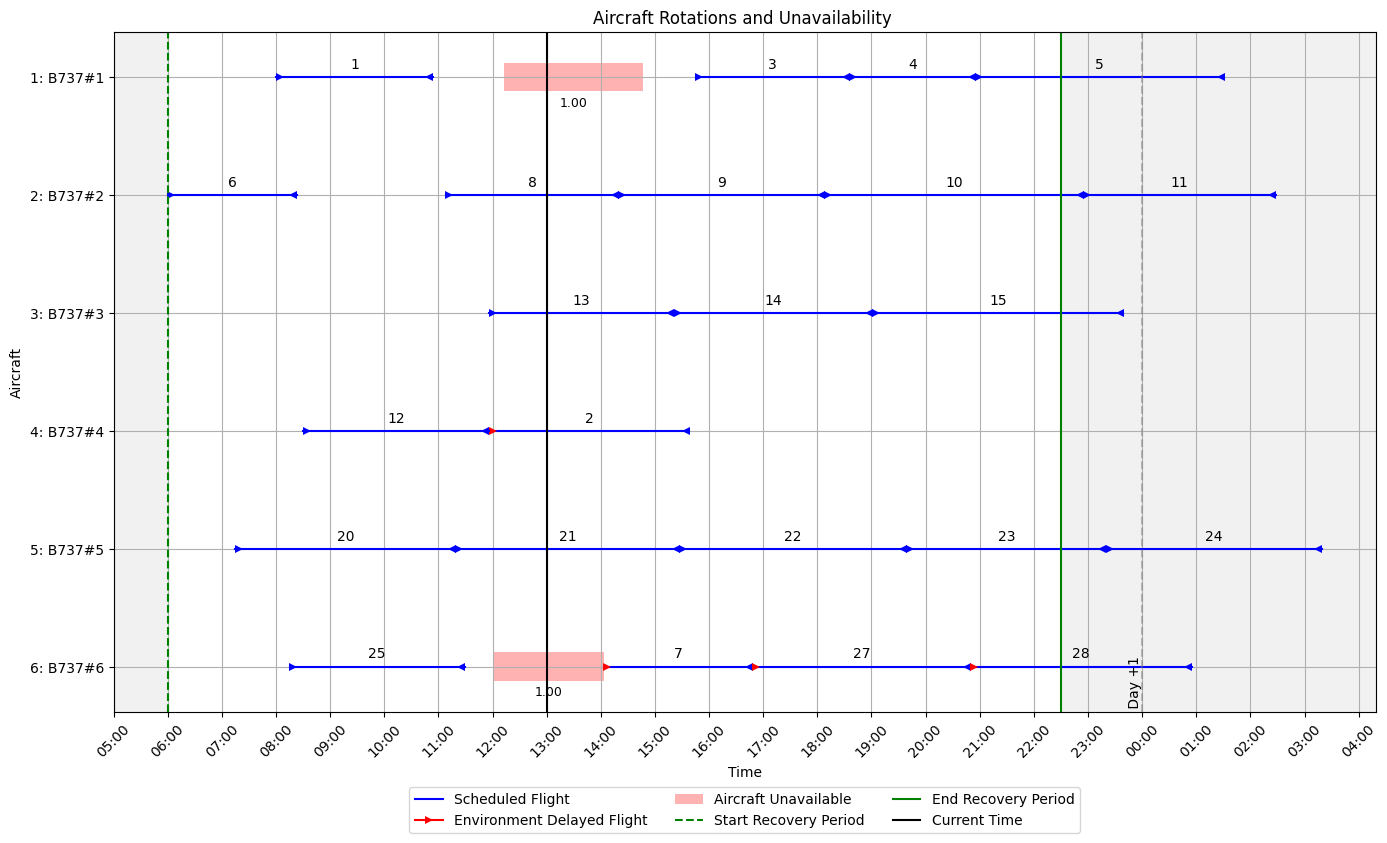

Total Reward: 110689.0


In [3]:
import sys
sys.path.append("..")
import os
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta
from src.environment import AircraftDisruptionEnv, AircraftDisruptionOptimizer
from scripts.visualizations import StatePlotter
from src.config import TIMESTEP_HOURS
import time


# Run the random agent
def run_random_agent(scenario_folder):
    # Set a random seed based on the current second in time
    current_seed = int(time.time() * 1e9) % (2**32 - 1)
    print(current_seed)
    np.random.seed(current_seed)

    # Load the scenario data
    data_dict = load_scenario_data(scenario_folder)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize the environment
    env = AircraftDisruptionEnv(aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict,  env_type=env_type)
    # Removed DummyVecEnv wrapping

    # Reset the environment
    obs, info = env.reset()
    if DEBUG_MODE_VISUALIZATION:
        print("Observation keys:", obs.keys())

    done = False
    total_reward = 0
    step_num = 0

    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=env.aircraft_dict,
        flights_dict=env.flights_dict,
        rotations_dict=env.rotations_dict,
        alt_aircraft_dict=env.alt_aircraft_dict,
        start_datetime=env.start_datetime,
        end_datetime=env.end_datetime,
        uncertain_breakdowns=env.uncertain_breakdowns,
    )

    # Print state nicely
    print("Initial State:")

    while not done:
        # Visualize the environment at each step
        print(f"Step {step_num}:")

        # Extract necessary information from the environment for plotting
        swapped_flights = env.swapped_flights
        environment_delayed_flights = env.environment_delayed_flights
        current_datetime = env.current_datetime

        # Retrieve the updated dictionaries from the environment
        updated_flights_dict = env.flights_dict
        updated_rotations_dict = env.rotations_dict
        updated_alt_aircraft_dict = env.alt_aircraft_dict
        cancelled_flights = env.penalized_cancelled_flights

        if DEBUG_MODE_VISUALIZATION:
            print("Flights Dict:")
            print(updated_flights_dict)
            print("Alt Aircraft Dict:")
            print(updated_alt_aircraft_dict)
            print("Swapped Flights:")
            print(swapped_flights)
            print("Environment Delayed Flights:")
            print(environment_delayed_flights)
            print("Cancelled Flights:")
            print(cancelled_flights)
            print("Unavailabilities:")
            print(env.alt_aircraft_dict)
            print("Uncertain Breakdowns:")
            for key, value in env.uncertain_breakdowns.items():
                print(f"{key}: {value}")
            print("Current Breakdowns:")
            print(env.current_breakdowns)
            print("")

        # Update the StatePlotter's dictionaries with the updated ones
        state_plotter.alt_aircraft_dict = updated_alt_aircraft_dict
        state_plotter.flights_dict = updated_flights_dict
        state_plotter.rotations_dict = updated_rotations_dict

        # Plot the state using the updated dictionaries
        state_plotter.plot_state(
            updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime
        )

        # Get the action mask from the environment
        action_mask = np.array(obs['action_mask'], dtype=float)
        # print(f"action_mask: {len(action_mask)}")
        # print(f"len action mask where value is 1: {len(np.where(action_mask == 1)[0])}")
        # print(f"at current datetime: {current_datetime}")
        np.set_printoptions(suppress=True, precision=1)

        # Convert observation to float32
        obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}
        # print_state_nicely(env.state)
        print("")

        # Select an action using 50/50 split between greedy and random
        valid_actions = np.where(action_mask == 1)[0]
        
        # Randomly decide between greedy and random action (50/50 chance)
        if np.random.rand() < 0.9:
            # Use the conflicted environment to select action
            from src.environment import AircraftDisruptionConflicted
            # Create a copy of the current environment state for the conflicted env
            conflicted_env = AircraftDisruptionConflicted(
                aircraft_dict=env.aircraft_dict,
                flights_dict=env.flights_dict,
                rotations_dict=env.rotations_dict,
                alt_aircraft_dict=env.alt_aircraft_dict,
                config_dict=env.config_dict
            )
            # Set the conflicted env's state to match current environment
            conflicted_env.current_datetime = env.current_datetime
            conflicted_env.state = env.state.copy()
            conflicted_env.unavailabilities_dict = env.unavailabilities_dict.copy()
            conflicted_env.cancelled_flights = env.cancelled_flights.copy()
            conflicted_env.environment_delayed_flights = env.environment_delayed_flights.copy()
            conflicted_env.penalized_delays = env.penalized_delays.copy()
            conflicted_env.penalized_cancelled_flights = env.penalized_cancelled_flights.copy()
            conflicted_env.initial_conflict_combinations = env.initial_conflict_combinations
            conflicted_env.eligible_flights_for_resolved_bonus = env.eligible_flights_for_resolved_bonus
            conflicted_env.eligible_flights_for_not_being_cancelled_when_disruption_happens = env.eligible_flights_for_not_being_cancelled_when_disruption_happens
            conflicted_env.scenario_wide_initial_disrupted_flights_list = env.scenario_wide_initial_disrupted_flights_list
            conflicted_env.scenario_wide_actual_disrupted_flights = env.scenario_wide_actual_disrupted_flights
            conflicted_env.something_happened = False
            conflicted_env.tail_swap_happened = False
            conflicted_env.scenario_wide_reward_components = env.scenario_wide_reward_components.copy()
            conflicted_env.scenario_wide_delay_minutes = env.scenario_wide_delay_minutes
            conflicted_env.scenario_wide_cancelled_flights = env.scenario_wide_cancelled_flights
            conflicted_env.scenario_wide_steps = env.scenario_wide_steps
            conflicted_env.scenario_wide_resolved_conflicts = env.scenario_wide_resolved_conflicts
            conflicted_env.scenario_wide_solution_slack = env.scenario_wide_solution_slack
            conflicted_env.scenario_wide_tail_swaps = env.scenario_wide_tail_swaps
            conflicted_env.info_after_step = {}
            # Get action mask from conflicted env
            action_mask = conflicted_env.get_action_mask()
            # Choose random action from valid actions in the restricted mask
            valid_actions = np.where(action_mask == 1)[0]
            
                        
            action_index = np.random.choice(valid_actions)
            action_reason = "conflicted-random"
        else:
            # Random exploration
            action_index = np.random.choice(valid_actions)
            action_reason = "exploration"

        print(f"Action selected via: {action_reason}")

        action = env.map_index_to_action(action_index)
        print(f"Action: Flight {action[0]}, Aircraft {action[1]}")

        # Step the environment
        obs, reward, terminated, truncated, info = env.step(action_index)

        # Determine if the episode is done
        done = terminated or truncated

        # Accumulate the reward
        total_reward += reward

        # Print action taken and reward
        action = env.map_index_to_action(action_index)
        print(f"Action taken: Flight {action[0]}, Aircraft {action[1]}, Reward: {reward}")
        print("")

        step_num += 1

    # Final plot after the simulation ends
    state_plotter.plot_state(
        updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime+timedelta(hours=TIMESTEP_HOURS)
    )

    print(f"Total Reward: {total_reward}")

env_type = "proactive"

SCENARIO_FOLDER = "../data/Training/6ac-10-superdiverse/Scenario_00010"

# Verify folder exists
if not os.path.exists(SCENARIO_FOLDER):
    raise FileNotFoundError(f"Scenario folder not found: {SCENARIO_FOLDER}")

# Run the random agent
run_random_agent(SCENARIO_FOLDER)
